In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
import pandas as pd
import anndata as ad
import random
import torch
import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs
os.environ['CUDA_VISIBLE_DEVICE']='1'
torch.cuda.set_device(1)
torch.cuda.current_device()

/data/lyx/software/anaconda3/envs/cell2location/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/lyx/software/anaconda3/envs/cell2location/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/data/lyx/software/anaconda3/envs/cell2location/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


1

In [2]:
def setup_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    # tf.random.set_seed(seed)  # set random seed for tensorflow-cpu
    # os.environ['TF_DETERMINISTIC_OPS'] = '1' # set random seed for tensorflow-gpu

seed = 90
setup_seed(seed)

In [3]:
data_dir = os.path.join(os.getcwd(),"benchmark_data","MERFISH")

In [4]:
sc_count = pd.read_table(os.path.join(data_dir,"sc_data","MERFISH_ID1_0.01_sc_data_transpose.tsv"),index_col=0)
st_count = pd.read_table(os.path.join(data_dir,"ST_data","MERFISH_ID1_50_data_0.01_transpose.tsv"), index_col=0)
sc_label = pd.read_table(os.path.join(data_dir,"sc_data","MERFISH_ID1_sc_label.tsv"),index_col=0)

In [5]:
data = st_count / 10000 * st_count.sum()
data = data.astype(int) # make integer
adata_st = ad.AnnData(data.transpose())
adata_st.obs_names = pd.Index(data.columns)
adata_st.var_names = data.index
adata_st

AnnData object with n_obs × n_vars = 1193 × 154

In [6]:
adata_sc = ad.AnnData(sc_count.transpose())
adata_sc.obs_names = pd.Index(sc_count.columns)
adata_sc.var_names = sc_count.index

In [7]:
results_folder = os.path.join(os.getcwd(),"benchmark","MERFISH","c2l")

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [8]:
adata_st.var['SYMBOL'] = adata_st.var_names
adata_st.var['gene_ids'] = adata_st.var['SYMBOL']
adata_st.var.set_index('gene_ids', drop=True, inplace=True)

adata_sc.var['SYMBOL'] = adata_sc.var.index
adata_sc.var['GeneID-2'] = adata_sc.var['SYMBOL']
# rename 'GeneID-2' as necessary for your data
adata_sc.var.set_index('GeneID-2', drop=True, inplace=True)


In [9]:
adata_sc.obs['Sample']='batch1'
adata_sc.obs['Subset'] = sc_label['bio_celltype']

/data/lyx/software/anaconda3/envs/cell2location/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


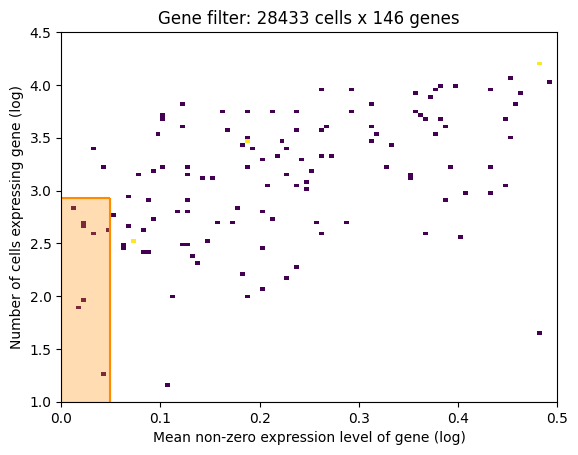

In [10]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_sc, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_sc = adata_sc[:, selected].copy()

In [11]:
selected

Index(['Pgr', 'Isl1', 'Sox8', 'Gal', 'Oprk1', 'Sytl4', 'Tacr1', 'Crh',
       'Opalin', 'Cspg5',
       ...
       'Ano3', 'Htr2c', 'Cd24a', 'Rgs2', 'Esr1', 'Slc17a7', 'Slc15a3',
       'Adora2a', 'Slc17a6', 'Prlr'],
      dtype='object', name='GeneID-2', length=146)

In [12]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_sc,
                        # 10X reaction / sample / batch
                        batch_key='Sample',
                        # cell type, covariate used for constructing signatures
                        labels_key='Subset'
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        # categorical_covariate_keys=['Method']
                       )

I0000 00:00:1700617576.659901  120501 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [13]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_sc)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.3.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample',
│   'labels_key': 'Subset',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 28433 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  10   │
│          n_vars          │  146  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample'] │   batch1   │          0          │
└─────────────────────┴────────────┴─────────────────────┘

                         labels State Registry                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃        Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Subset'] │        Ambiguous         │          0          │
│                     │        Astrocyte         │          1          │
│                     │       Endothelial        │          2          │
│                     │        Ependymal         │          3          │
│                     │        Excitatory        │          4          │
│                     │ Immature_oligodendrocyte │          5          │
│                     │        Inhibitory        │          6          │
│                     │  Mature_oligodendrocyte  │          7          │
│                     │        Microglia         │          8          │
│                     │          Mural           │          9          │
└─────────────────────┴──────────────────────────┴─────────────────────┘

In [14]:
mod.train(max_epochs=300, use_gpu=True)

/data/lyx/software/anaconda3/envs/cell2location/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/lyx/software/anaconda3/envs/cell2location/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 300/300: 100%|██████████| 300/300 [05:49<00:00,  1.22s/it, v_num=1, elbo_train=2.01e+6]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [05:49<00:00,  1.16s/it, v_num=1, elbo_train=2.01e+6]


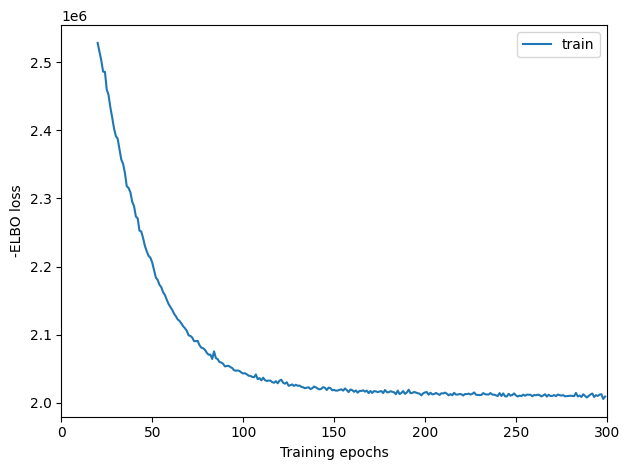

In [15]:
mod.plot_history(20)

In [16]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_sc = mod.export_posterior(
    adata_sc, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}/ID1_0.01_50_model_sc_{seed}.pt", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/ID1_0.01_50_sc_{seed}.h5ad"

/data/lyx/software/anaconda3/envs/cell2location/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|██████████| 999/999 [00:24<00:00, 41.29it/s] 


In [17]:
adata_sc.write(adata_file)
adata_file

'/data/lyx/hubs/SpaTD/stdgcn/benchmark/MERFISH/c2l/reference_signatures/ID1_0.01_50_sc_90.h5ad'

In [18]:
adata_sc = mod.export_posterior(
    adata_sc, use_quantiles=True,
    # choose quantiles
    add_to_varm=["q05","q50", "q95", "q0001"],
    sample_kwargs={'batch_size': 2500, 'use_gpu': True}
)

In [19]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_sc.varm.keys():
    inf_aver = adata_sc.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_sc.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_sc.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_sc.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_sc.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,Ambiguous,Astrocyte,Endothelial,Ependymal,Excitatory
GeneID-2,,,,,
Pgr,0.221588,0.050162,0.023026,0.030604,0.352122
Isl1,0.598211,0.124173,0.063707,0.109780,0.230975
Sox8,0.467079,0.413224,0.053302,0.171069,0.027413
Gal,0.923988,0.241922,0.343573,0.350655,1.005145
Oprk1,0.234566,0.050771,0.067357,0.046150,0.195237


In [20]:
adata_st.obs['sample'] = 'batch1'

In [21]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_st.var_names, inf_aver.index)
adata_st = adata_st[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_st, batch_key="sample")

/data/lyx/software/anaconda3/envs/cell2location/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [22]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_st, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.3.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 1193  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │  146  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │   batch1   │          0          │
└─────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [23]:
mod.train(max_epochs=15000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True,
         )

/data/lyx/software/anaconda3/envs/cell2location/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/lyx/software/anaconda3/envs/cell2location/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/data/lyx/software/anaconda3/envs/cell2location/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is small

Epoch 15000/15000: 100%|██████████| 15000/15000 [1:04:01<00:00,  3.77it/s, v_num=1, elbo_train=1.78e+5]

`Trainer.fit` stopped: `max_epochs=15000` reached.


Epoch 15000/15000: 100%|██████████| 15000/15000 [1:04:01<00:00,  3.90it/s, v_num=1, elbo_train=1.78e+5]


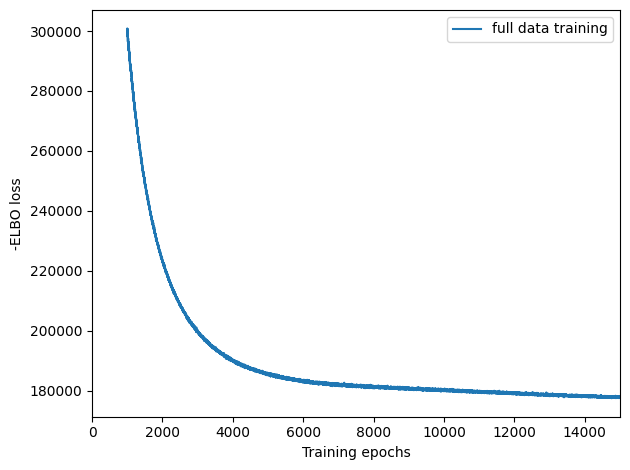

In [24]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training'])

In [25]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_st, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}/ID1_0.01_50_model_sp_{seed}.pt", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/ID1_0.01_50_sp_{seed}.h5ad"
adata_vis.write(adata_file)

/data/lyx/software/anaconda3/envs/cell2location/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|██████████| 999/999 [01:04<00:00, 15.45it/s]


In [26]:
adata_vis.obs

,sample,_indices,_scvi_batch,_scvi_labels
gr_1096,batch1,0,0,0
gr_812,batch1,1,0,0
gr_954,batch1,2,0,0
gr_670,batch1,3,0,0
gr_1097,batch1,4,0,0
...,...,...,...,...
gr_5675,batch1,1188,0,0
gr_5391,batch1,1189,0,0
gr_5533,batch1,1190,0,0
gr_5816,batch1,1191,0,0


In [27]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

In [28]:
adata_vis.obs.columns

Index(['sample', '_indices', '_scvi_batch', '_scvi_labels', 'Ambiguous',
       'Astrocyte', 'Endothelial', 'Ependymal', 'Excitatory',
       'Immature_oligodendrocyte', 'Inhibitory', 'Mature_oligodendrocyte',
       'Microglia', 'Mural'],
      dtype='object')

In [29]:
adata_vis.obs[['Ambiguous',
       'Astrocyte', 'Endothelial', 'Ependymal', 'Excitatory',
       'Immature_oligodendrocyte', 'Inhibitory', 'Mature_oligodendrocyte',
       'Microglia', 'Mural']].to_csv("./benchmark/MERFISH/ID1/Bregma0.01/c2l_50_pred_{}.csv".format(seed))

In [30]:
"./benchmark/MERFISH/ID1/Bregma0.01/c2l_50_pred_{}.csv".format(seed)

'./benchmark/MERFISH/ID1/Bregma0.01/c2l_50_pred_90.csv'